<a href="https://colab.research.google.com/github/dimanghaz/wd-workshop/blob/main/Wday_workshop_bq_fin_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Copyright 2023 Google LLC

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#      https://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# For Workday Meeting

#Disclaimer: EXPERIMENTAL CODE!!!

# What we will do?
* Generate a paragraph of Financial report with few-shot prompting.
* We will use two examples and provide a json fincial structure and ask VertexAI PaLm to generate the paragraph.
* Architecture:- We will use LangChain + VertextAI + BigQuery

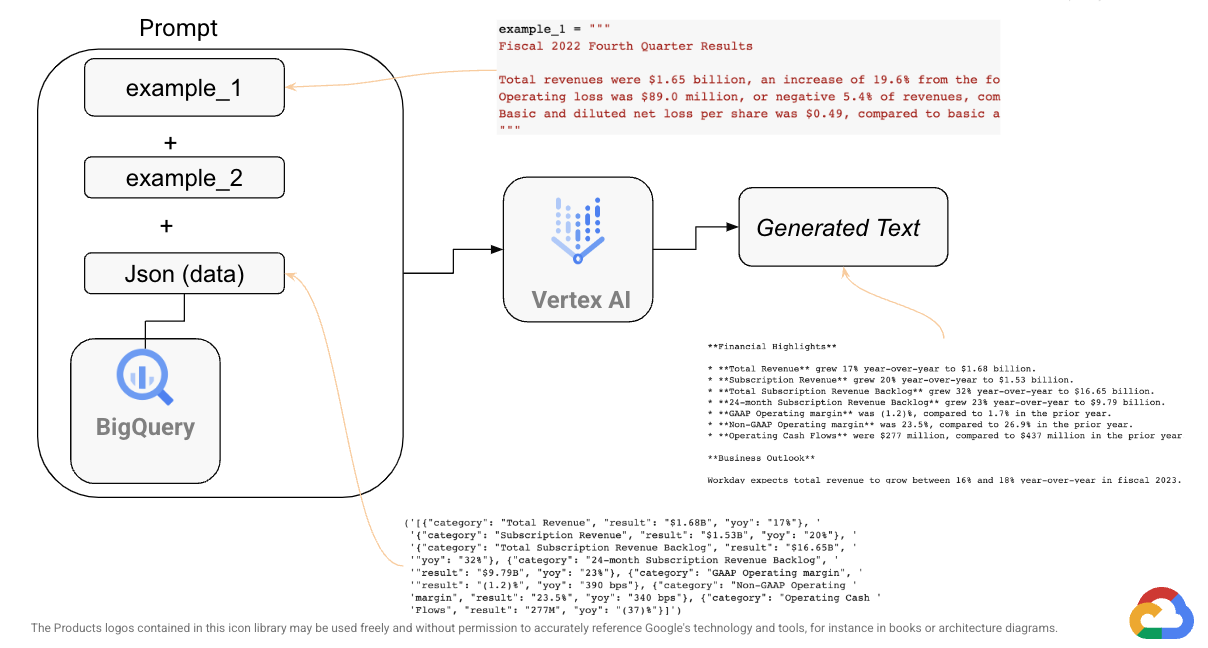

# How we will do?
1. Setup - install packages and outh
1. Setup Test Data in BigQuery (use BigQuery python sdk)
1. Grab all records (BigQuerySQL Loader)
1. Try Q&A with the test data (use SQLDatabaseChain)
1. (optional) wrap it in Graddle UI
1. Generate the financial pargraph text
1. Chain the db and the llm (SequentialChain - SQLDatabaseChain + LLMChain)

Exercise: _Repeat the above steps_ to grab info from other data sources (e.g. a REST API call)


#Setup

## pip install packages

In [ ]:
# You need to restart the runtime
# Install Vertex AI LLM SDK
! pip install google-cloud-aiplatform langchain sqlalchemy sqlalchemy-bigquery --upgrade --user

# BQ
!pip install google-cloud-bigquery

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 23.3 MB/s eta 0:00:00


## Intialize variables

In [ ]:
# PROJECT_ID='genai-hackathon-005'
# DATASET_ID = 'wday_workshop'
# BQ_DATASET_LOCATION = 'US'
# TABLE_FIN_HIGHLIGHT_NAME = 'workday_q1_financial_highlights'

PROJECT_ID='dp-genai-bb'
DATASET_ID = 'wday_workshop'
BQ_DATASET_LOCATION = 'US'
TABLE_FIN_HIGHLIGHT_NAME = 'workday_q1_financial_highlights'

## Google Cloud authentication

### `Using Service Account`

In [ ]:
# # Google Cloud Authentication
# # upload your xxx.json sa key
# from google.colab import files
# upload = files.upload()

In [ ]:
# import os
# os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = list(upload)[0]
# # set the account
# !echo "Setting Service Account:" $GOOGLE_APPLICATION_CREDENTIALS
# !gcloud auth activate-service-account --key-file=$GOOGLE_APPLICATION_CREDENTIALS

### `Using oauth`

In [ ]:
from google.colab import auth as google_auth
google_auth.authenticate_user()

In [ ]:
# gcloud project - used by the gcloud cmd
!gcloud config set project $PROJECT_ID

Updated property [core/project].


In [ ]:
# set the proper Permission for the required Google Cloud Services
!gcloud services enable \
    storage-component.googleapis.com \
    bigquery.googleapis.com \
    ml.googleapis.com \
    notebooks.googleapis.com \
    cloudfunctions.googleapis.com \
    cloudbuild.googleapis.com

Operation "operations/acf.p2-762272318557-18bb3f87-5292-4358-8fc2-1e0b49ccca16" finished successfully.


#Test Data Preparation

##BigQuery data setup

### BQ Utility functions

In [ ]:
def create_dataset(dataset_id: str, location:str, description: str):
    from google.cloud import bigquery
    from google.cloud.exceptions import NotFound

    # Construct a BigQuery client object.
    client = bigquery.Client()

    try:
        client.get_dataset(dataset_id)  # Make an API request.
        print("Dataset {} already exists".format(dataset_id))
    except NotFound:
        print("Dataset {} is not found".format(dataset_id))

        # TODO(developer): Set dataset_id to the ID of the dataset to create.
        # dataset_id = "{}.your_dataset".format(client.project)

        # Construct a full Dataset object to send to the API.
        dataset = bigquery.Dataset(dataset_id)
        dataset.description = description

        # TODO(developer): Specify the geographic location where the dataset should reside.
        dataset.location = location

        # Send the dataset to the API for creation, with an explicit timeout.
        # Raises google.api_core.exceptions.Conflict if the Dataset already
        # exists within the project.
        dataset = client.create_dataset(dataset, timeout=30)  # Make an API request.
        print("Created dataset ".format(dataset.dataset_id))


In [ ]:
def execute_query(project_id:str, query: str):
  # [START bigquery_query]

  from google.cloud import bigquery

  # Construct a BigQuery client object.
  client = bigquery.Client(project=project_id)

  print(f"Going to execute the sql{query}...")
  client.query(query)  # Make an API request.
  print("Query executed.")

  # [END bigquery_query]

In [ ]:
def table_insert_rows(project_id:str, table_id:str, rows_to_insert:str):

    # [START bigquery_table_insert_rows]
    from google.cloud import bigquery

    # Construct a BigQuery client object.
    client = bigquery.Client(project=project_id)

    # TODO(developer): Set table_id to the ID of table to append to.
    # table_id = "your-project.your_dataset.your_table"

    errors = client.insert_rows_json(table_id, rows_to_insert)  # Make an API request.
    if errors == []:
        print("New rows have been added.")
    else:
        print("Encountered errors while inserting rows: {}".format(errors))
    # [END bigquery_table_insert_rows]

## Create BiqQuery test data

In [ ]:
# create a dataset to upload Workday Q1 FY24 Financial Highlights data (slide #13)
# https://www.workday.com/content/dam/web/en-us/documents/investor/workday-fiscal-2024-first-quarter-investor-presentation.pdf
create_dataset(dataset_id=f'{PROJECT_ID}.{DATASET_ID}', location=BQ_DATASET_LOCATION, description='Workday Q1 FY24 Financial Highlights')

Dataset dp-genai-bb.wday_workshop is not found
Created dataset 


In [ ]:
# create table to hold the fin information
q1_fin_highlights_query = f"""
CREATE OR REPLACE TABLE `{DATASET_ID}.{TABLE_FIN_HIGHLIGHT_NAME}`
  (
    category STRING OPTIONS(description="Holds the first column data e.g. Revenue"),
    result STRING OPTIONS(description="Holds the result data e.g. $1.68B"),
    yoy STRING OPTIONS(description="Holds the you data e.g. 17%"),
  ) OPTIONS(description="Q1 FY24 Financial Highlights")
"""
execute_query(PROJECT_ID, q1_fin_highlights_query)

Going to execute the sql
CREATE OR REPLACE TABLE `wday_workshop.workday_q1_financial_highlights`
  (
    category STRING OPTIONS(description="Holds the first column data e.g. Revenue"),
    result STRING OPTIONS(description="Holds the result data e.g. $1.68B"),
    yoy STRING OPTIONS(description="Holds the you data e.g. 17%"),
  ) OPTIONS(description="Q1 FY24 Financial Highlights")
...
Query executed.


In [ ]:
# create the financial test data
rows_to_insert = [
    {u"category": u"Total Revenue", u"result": u"$1.68B", u"yoy": u"17%"},
    {u"category": u"Subscription Revenue", u"result": u"$1.53B", u"yoy": u"20%"},
    {u"category": u"Total Subscription Revenue Backlog", u"result": u"$16.65B", u"yoy": u"32%"},
    {u"category": u"24-month Subscription Revenue Backlog", u"result": u"$9.79B", u"yoy": u"23%"},
    {u"category": u"GAAP Operating margin", u"result": u"(1.2)%", u"yoy": u"390 bps"},
    {u"category": u"Non-GAAP Operating margin", u"result": u"23.5%", u"yoy": u"340 bps"},
    {u"category": u"Operating Cash Flows", u"result": u"277M", u"yoy": u"(37)%"},
]
table_insert_rows(PROJECT_ID, f"{PROJECT_ID}.{DATASET_ID}.{TABLE_FIN_HIGHLIGHT_NAME}", rows_to_insert)


New rows have been added.


# Query BigQuery Dataset

<!-- ## Get BQ data using LangChan BigQueryLoader -->

## DB chain - SQLDatabaseChain

In [ ]:
from sqlalchemy import *
from sqlalchemy.schema import *
def query_llm_vertexai (query):
    from langchain.sql_database import SQLDatabase
    from langchain.llms import VertexAI
    from sqlalchemy.engine import create_engine
    import vertexai

    from langchain.chains import SQLDatabaseChain
    from langchain.prompts.prompt import PromptTemplate

    PROJECT_ID = "genai-hackathon-005"
    try:
        vertexai.init(project=PROJECT_ID, location="us-central1")
    except Exception as e:
        print (e)

    llm = VertexAI(temperature=0, verbose=True, top_k=40, top_p=0.8, max_output_tokens=256)

    engine = create_engine(f'bigquery://{PROJECT_ID}/{DATASET_ID}')

    table_names=[]
    table_names.append(TABLE_FIN_HIGHLIGHT_NAME)

    db = SQLDatabase(engine=engine,metadata=MetaData(bind=engine),include_tables=[x for x in table_names])
    db_chain = SQLDatabaseChain(llm=llm, database=db, verbose=True, return_intermediate_steps=True)

    #Define prompt for BigQuery SQL
    _googlesql_prompt = """You are a GoogleSQL expert. Given an input question, first create a syntactically correct GoogleSQL query to run, then look at the results of the query and return the answer to the input question.
    Unless the user specifies in the question a specific number of examples to obtain, query for at most {top_k} results using the LIMIT clause as per GoogleSQL. You can order the results to return the most informative data in the database.
    Never query for all columns from a table. You must query only the columns that are needed to answer the question. Wrap each column name in backticks (`) to denote them as delimited identifiers.
    Pay attention to use only the column names you can see in the tables below. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.
    Use the following format:
    Question: "Question here"
    SQLQuery: "SQL Query to run"
    SQLResult: "Result of the SQLQuery"
    Answer: "Final answer here"
    Only use the following tables:
    {table_info}

    If someone asks for aggregation on a STRING data type column, then CAST column as NUMERIC before you do the aggregation.

    If someone asks for specific month, use ActivityDate between current month's start date and current month's end date

    If someone asks for column names in the table, use the following format:
    SELECT column_name
    FROM `{project_id}.{dataset_id}`.INFORMATION_SCHEMA.COLUMNS
    WHERE table_name in {table_info}

    Question: {input}"""

    GOOGLESQL_PROMPT = PromptTemplate(
        input_variables=["input", "table_info", "top_k", "project_id", "dataset_id"],
        template=_googlesql_prompt,
    )

    #passing question to the prompt template
    final_prompt = GOOGLESQL_PROMPT.format(input=query,
            project_id =PROJECT_ID, dataset_id=DATASET_ID,
            table_info=table_names, top_k=10000)

    #pass final prompt to SQL Chain
    output = db_chain(final_prompt)

    return output['result'], output['intermediate_steps'][1]


### Query BigQuery Database
* What is the Total Revenue?
* What is the Subscription Revenue?

In [ ]:
questions = []
questions.append ('What is the Total Revenue?')
questions.append ('What is the Subscription Revenue?')
# questions.append ('Can you get all the records in a json format?')

# print (questions)
for each_question in questions:
    print(f'question: {each_question}, answer: {query_llm_vertexai(each_question)}')

<ipython-input-17-dd05c1b6a8f1>:25: RemovedIn20Warning: Deprecated API features detected! These feature(s) are not compatible with SQLAlchemy 2.0. To prevent incompatible upgrades prior to updating applications, ensure requirements files are pinned to "sqlalchemy<2.0". Set environment variable SQLALCHEMY_WARN_20=1 to show all deprecation warnings.  Set environment variable SQLALCHEMY_SILENCE_UBER_WARNING=1 to silence this message. (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  db = SQLDatabase(engine=engine,metadata=MetaData(bind=engine),include_tables=[x for x in table_names])
/root/.local/lib/python3.10/site-packages/langchain/chains/sql_database/base.py:63: UserWarning: Directly instantiating an SQLDatabaseChain with an llm is deprecated. Please instantiate with llm_chain argument or using the from_llm class method.
  warnings.warn(




> Entering new  chain...
You are a GoogleSQL expert. Given an input question, first create a syntactically correct GoogleSQL query to run, then look at the results of the query and return the answer to the input question.
    Unless the user specifies in the question a specific number of examples to obtain, query for at most 10000 results using the LIMIT clause as per GoogleSQL. You can order the results to return the most informative data in the database.
    Never query for all columns from a table. You must query only the columns that are needed to answer the question. Wrap each column name in backticks (`) to denote them as delimited identifiers.
    Pay attention to use only the column names you can see in the tables below. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.
    Use the following format:
    Question: "Question here"
    SQLQuery: "SQL Query to run"
    SQLResult: "Result of the SQLQuery"
    Answer: "Fin

## UI Query BQ Fin data (optional)

In [ ]:
!pip install gradio --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 61.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.8/288.8 kB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 5.1 MB/s eta 0:

In [ ]:
import gradio as gr

with gr.Blocks() as demo:
    gr.Markdown(
    """
    ## Ask the Financial Data question

    ### Sample Inputs:
    1. What is the highest yoy growth category?
    2. What are the financial highlights?
    3. What is the Total Revenue?

    ### Enter a search query...

    """)
    with gr.Row():
      with gr.Column():
        input_text = gr.Textbox(label="Question", placeholder="What is the highest yoy growth category?")

    with gr.Row():
      generate = gr.Button("Ask BigQuery")

    with gr.Row():
      label2 = gr.Textbox(label="Output")
    with gr.Row():
      label3 = gr.Textbox(label="SQL query generated by LLM")

    generate.click(query_llm_vertexai, input_text, [label2, label3])
demo.launch(share=False, debug=False)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

# Text Generation
<!-- https://newsroom.workday.com/2023-05-25-Workday-Announces-Fiscal-2024-First-Quarter-Financial-Results -->

## Financial report generation

### Two examples

In [ ]:
# https://newsroom.workday.com/2023-05-25-Workday-Announces-Fiscal-2024-First-Quarter-Financial-Results <-- generate
# example_1 = """
# Fiscal 2024 First Quarter Results

# Total revenues were $1.68 billion, an increase of 17.4% from the first quarter of fiscal 2023. Subscription revenues were $1.53 billion, an increase of 20.1% from the same period last year.
# Operating loss was $19.8 million, or negative 1.2% of revenues, compared to an operating loss of $72.8 million, or negative 5.1% of revenues, in the same period last year. Non-GAAP operating income for the first quarter was $395.9 million, or 23.5% of revenues, compared to a non-GAAP operating income of $288.6 million, or 20.1% of revenues, in the same period last year.1
# Basic and diluted net income per share was $0.00, compared to basic and diluted net loss per share of $0.41 in the first quarter of fiscal 2023. Non-GAAP basic and diluted net income per share was $1.32 and $1.31, respectively, compared to non-GAAP basic and diluted net income per share of $0.86 and $0.83, respectively, in the same period last year.2
# Operating cash flows were $277.3 million compared to $439.7 million in the prior year.
# Cash, cash equivalents, and marketable securities were $6.33 billion as of April 30, 2023.
# """
example_1 = """
Fiscal 2022 Fourth Quarter Results

Total revenues were $1.65 billion, an increase of 19.6% from the fourth quarter of fiscal 2022. Subscription revenues were $1.50 billion, an increase of 21.7% from the same period last year.
Operating loss was $89.0 million, or negative 5.4% of revenues, compared to an operating loss of $101.0 million, or negative 7.3% of revenues, in the same period last year. Non-GAAP operating income for the fourth quarter was $305.3 million, or 18.5% of revenues, compared to a non-GAAP operating income of $237.1 million, or 17.2% of revenues, in the same period last year.1
Basic and diluted net loss per share was $0.49, compared to basic and diluted net loss per share of $0.29 in the fourth quarter of fiscal 2022. Non-GAAP basic and diluted net income per share was $1.00 and $0.99, respectively, compared to non-GAAP basic and diluted net income per share of $0.82 and $0.78, respectively, in the same period last year.2
"""

example_2 = """
Fiscal 2022 Third Quarter Results

Total revenues were $1.60 billion, an increase of 20.5% from the third quarter of fiscal 2022. Subscription revenues were $1.43 billion, an increase of 22.3% from the same period last year.
Operating loss was $26.3 million, or negative 1.6% of revenues, compared to an operating income of $23.9 million, or 1.8% of revenues, in the same period last year. Non-GAAP operating income for the third quarter was $314.2 million, or 19.7% of revenues, compared to a non-GAAP operating income of $332.2 million, or 25.0% of revenues, in the same period last year.1
Basic and diluted net loss per share was $0.29, compared to basic and diluted net income per share of $0.17 in the third quarter of fiscal 2022. Non-GAAP basic and diluted net income per share was $1.01 and $0.99, respectively, compared to non-GAAP basic and diluted net income per share of $1.15 and $1.10, respectively, in the same period last year.2
Operating cash flows were $408.7 million compared to $384.7 million in the prior year.
Cash, cash equivalents, and marketable securities were $5.49 billion as of October 31, 2022.
"""

### Get all fin data in Json format

In [ ]:
# we are feeding to the prompt to generate a parah for the financial report
all_record_json = query_llm_vertexai('Can you get all the records in a json format?')[0]



> Entering new  chain...
You are a GoogleSQL expert. Given an input question, first create a syntactically correct GoogleSQL query to run, then look at the results of the query and return the answer to the input question.
    Unless the user specifies in the question a specific number of examples to obtain, query for at most 10000 results using the LIMIT clause as per GoogleSQL. You can order the results to return the most informative data in the database.
    Never query for all columns from a table. You must query only the columns that are needed to answer the question. Wrap each column name in backticks (`) to denote them as delimited identifiers.
    Pay attention to use only the column names you can see in the tables below. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.
    Use the following format:
    Question: "Question here"
    SQLQuery: "SQL Query to run"
    SQLResult: "Result of the SQLQuery"
    Answer: "Fin

In [ ]:
import pprint
pprint.pprint(all_record_json)


('[{"category": "Total Revenue", "result": "$1.68B", "yoy": "17%"}, '
 '{"category": "Subscription Revenue", "result": "$1.53B", "yoy": "20%"}, '
 '{"category": "Total Subscription Revenue Backlog", "result": "$16.65B", '
 '"yoy": "32%"}, {"category": "24-month Subscription Revenue Backlog", '
 '"result": "$9.79B", "yoy": "23%"}, {"category": "GAAP Operating margin", '
 '"result": "(1.2)%", "yoy": "390 bps"}, {"category": "Non-GAAP Operating '
 'margin", "result": "23.5%", "yoy": "340 bps"}, {"category": "Operating Cash '
 'Flows", "result": "277M", "yoy": "(37)%"}]')


### Test prompts with 2 examples and the json fin data

In [ ]:
from google.cloud import aiplatform
from langchain.llms import VertexAI
print(f"Vertex AI SDK version: {aiplatform.__version__}")

Vertex AI SDK version: 1.28.0


In [ ]:

# LLM model
llm = VertexAI(
    model_name="text-bison@001",
    max_output_tokens=256,
    temperature=0.1,
    top_p=0.8,
    top_k=40,
    verbose=True,
)

In [ ]:
final_prompt1 = f"""
You are an intelligent assistant helping a financial analyst to generate a financial report. Following are some examples delimited by triple back ticks:

```{example_1}```

```{example_2}```


Generate an in-depth report given the following financial information of the company:

{all_record_json}
"""

final_prompt2 = f"""
You are an intelligent assistant helping a financial analyst to generate a financial report.

Generate an in-depth report given the following financial information of the company:

{all_record_json}
"""

prompt_list = []
prompt_list.append (final_prompt1)
prompt_list.append (final_prompt2)


In [ ]:
for each_prompt in prompt_list:
  # print(each_prompt)
  print ('###########')
  print(llm(each_prompt))

###########
**Financial Highlights**

* Total revenue was $1.68 billion, an increase of 17% year-over-year (YoY).
* Subscription revenue was $1.53 billion, an increase of 20% YoY.
* Total subscription revenue backlog was $16.65 billion, an increase of 32% YoY.
* 24-month subscription revenue backlog was $9.79 billion, an increase of 23% YoY.
* GAAP operating margin was (1.2)%, an improvement of 390 basis points (bps) YoY.
* Non-GAAP operating margin was 23.5%, an improvement of 340 bps YoY.
* Operating cash flows were $277 million, a decrease of 37% YoY.

**Business Outlook**

The company expects total revenue to be between $1.70 billion and $1.72 billion in the fourth quarter of fiscal 2023, representing an increase of 15% to 17% YoY. Subscription revenue is expected to be between $1.55 billion and
###########
**Financial Report**

**Company Name:** [Company Name]

**Fiscal Year:** 2023

**Revenue:** $1.68 billion

**YoY Growth:** 17%

**Subscription Revenue:** $1.53 billion

**YoY Gr

## LangChain Chaining - Two chains

In [ ]:
from langchain.chains import SequentialChain
from langchain.sql_database import SQLDatabase
from langchain.llms import VertexAI
from sqlalchemy.engine import create_engine
from langchain.chains import LLMChain

from langchain.chains import SQLDatabaseChain
from langchain.prompts.prompt import PromptTemplate

llm = VertexAI(temperature=0, verbose=True, top_k=40, top_p=0.8, max_output_tokens=256)

engine = create_engine(f'bigquery://{PROJECT_ID}/{DATASET_ID}')

top_k=1000
#Define prompt for BigQuery SQL
_googlesql_prompt = f"""You are a GoogleSQL expert. Given an input question, first create a syntactically correct GoogleSQL query to run, then look at the results of the query and return the answer to the input question.
Unless the user specifies in the question a specific number of examples to obtain, query for at most {top_k} results using the LIMIT clause as per GoogleSQL. You can order the results to return the most informative data in the database.
Never query for all columns from a table. You must query only the columns that are needed to answer the question. Wrap each column name in backticks (`) to denote them as delimited identifiers.
Pay attention to use only the column names you can see in the tables below. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.
Use the following format:
Question: "Question here"
SQLQuery: "SQL Query to run"
SQLResult: "Result of the SQLQuery"
Answer: "Final answer here"
Only use the following tables:
{TABLE_FIN_HIGHLIGHT_NAME}

If someone asks for aggregation on a STRING data type column, then CAST column as NUMERIC before you do the aggregation.

If someone asks for specific month, use ActivityDate between current month's start date and current month's end date

If someone asks for column names in the table, use the following format:
SELECT column_name
FROM `{PROJECT_ID}.{DATASET_ID}`.INFORMATION_SCHEMA.COLUMNS
WHERE table_name in {TABLE_FIN_HIGHLIGHT_NAME}

Question: {{input}}"""

google_sql_prompt = PromptTemplate(
    input_variables=["input"],
    template=_googlesql_prompt,
)

db = SQLDatabase(engine=engine,metadata=MetaData(bind=engine),include_tables=[TABLE_FIN_HIGHLIGHT_NAME])
db_chain = SQLDatabaseChain(llm=llm, database=db, verbose=True, prompt=google_sql_prompt, output_key="all_fin_json")

_fin_prompt = """
You are an intelligent assistant helping a financial analyst to generate a financial report. Following are some examples delimited by triple back ticks:

```Fiscal 2022 Fourth Quarter Results

Total revenues were $1.65 billion, an increase of 19.6% from the fourth quarter of fiscal 2022. Subscription revenues were $1.50 billion, an increase of 21.7% from the same period last year.
Operating loss was $89.0 million, or negative 5.4% of revenues, compared to an operating loss of $101.0 million, or negative 7.3% of revenues, in the same period last year. Non-GAAP operating income for the fourth quarter was $305.3 million, or 18.5% of revenues, compared to a non-GAAP operating income of $237.1 million, or 17.2% of revenues, in the same period last year.1
Basic and diluted net loss per share was $0.49, compared to basic and diluted net loss per share of $0.29 in the fourth quarter of fiscal 2022. Non-GAAP basic and diluted net income per share was $1.00 and $0.99, respectively, compared to non-GAAP basic and diluted net income per share of $0.82 and $0.78, respectively, in the same period last year.2
```

```
Fiscal 2022 Third Quarter Results

Total revenues were $1.60 billion, an increase of 20.5% from the third quarter of fiscal 2022. Subscription revenues were $1.43 billion, an increase of 22.3% from the same period last year.
Operating loss was $26.3 million, or negative 1.6% of revenues, compared to an operating income of $23.9 million, or 1.8% of revenues, in the same period last year. Non-GAAP operating income for the third quarter was $314.2 million, or 19.7% of revenues, compared to a non-GAAP operating income of $332.2 million, or 25.0% of revenues, in the same period last year.1
Basic and diluted net loss per share was $0.29, compared to basic and diluted net income per share of $0.17 in the third quarter of fiscal 2022. Non-GAAP basic and diluted net income per share was $1.01 and $0.99, respectively, compared to non-GAAP basic and diluted net income per share of $1.15 and $1.10, respectively, in the same period last year.2
Operating cash flows were $408.7 million compared to $384.7 million in the prior year.
Cash, cash equivalents, and marketable securities were $5.49 billion as of October 31, 2022.
```

Generate an in-depth report given the following financial information of the company:

{all_fin_json}
"""

final_fin_report_prompt = PromptTemplate(
    input_variables=["all_fin_json"],
    template=_fin_prompt,
)

# chain 2: input=all_fin_json and output= summary
chain_two = LLMChain(llm=llm, prompt=final_fin_report_prompt,
                     output_key="summary", verbose=False,
                    )

# overall_chain: input=input<-- query
# and output= summary
overall_chain = SequentialChain(
    chains=[db_chain, chain_two],
    input_variables=["query"],
    output_variables=["summary"],
    verbose=True
)

query = 'Can you get all the records in a json format?'
overall_chain.run(query)




> Entering new  chain...


> Entering new  chain...
Can you get all the records in a json format?
SQLQuery:SELECT * FROM `dp-genai-bb.wday_workshop.workday_q1_financial_highlights`
SQLResult: [('Total Revenue', '$1.68B', '17%'), ('Subscription Revenue', '$1.53B', '20%'), ('Total Subscription Revenue Backlog', '$16.65B', '32%'), ('24-month Subscription Revenue Backlog', '$9.79B', '23%'), ('GAAP Operating margin', '(1.2)%', '390 bps'), ('Non-GAAP Operating margin', '23.5%', '340 bps'), ('Operating Cash Flows', '277M', '(37)%')]
Answer:[{"Total Revenue": "$1.68B", "Subscription Revenue": "$1.53B", "Total Subscription Revenue Backlog": "$16.65B", "24-month Subscription Revenue Backlog": "$9.79B", "GAAP Operating margin": "(1.2)%", "Non-GAAP Operating margin": "23.5%", "Operating Cash Flows": "277M"}]
> Finished chain.

> Finished chain.


'**Financial Highlights**\n\n* Total revenue was $1.68 billion, an increase of 19.6% year-over-year.\n* Subscription revenue was $1.53 billion, an increase of 21.7% year-over-year.\n* Total subscription revenue backlog was $16.65 billion, an increase of 19.6% year-over-year.\n* 24-month subscription revenue backlog was $9.79 billion, an increase of 21.7% year-over-year.\n* GAAP operating margin was (1.2)%, compared to 1.8% in the prior year.\n* Non-GAAP operating margin was 23.5%, compared to 25.0% in the prior year.\n* Operating cash flows were $277 million, compared to $384 million in the prior year.\n\n**Business Outlook**\n\nThe company expects total revenue to be between $1.70 billion and $1.72 billion in the fourth quarter of fiscal 2023. Subscription revenue is expected to be between $1.55 billion and $1'